# MODEL TRAINING

#### IMPORTING LIBRARIES AND ADDING BACKEND FOLDER TO PATH TO USE data_fetcher.py

In [1]:
# Import Libraries
import sys
import os

# Add backend to path
backend_path = os.path.abspath('../backend')
if backend_path not in sys.path:
    sys.path.append(backend_path)

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print("🚀 Starting Model Training with Upstox Data")

TensorFlow version: 2.16.1
🚀 Starting Model Training with Upstox Data


#### ENHANCED DATA PREPROCESSOR

In [12]:
class StockDataPreprocessor:
    def __init__(self, sequence_length=60):
        self.sequence_length = sequence_length
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        
    def prepare_features(self, data):
        """Add technical indicators as features"""
        data = data.copy()
        
        # Technical indicators
        data['SMA_10'] = data['Close'].rolling(10).mean()
        data['SMA_30'] = data['Close'].rolling(30).mean()
        data['RSI'] = self._calculate_rsi(data['Close'])
        data['MACD'] = self._calculate_macd(data['Close'])
        data['Volatility'] = data['Close'].pct_change().rolling(20).std()
        
        # Price ratios
        data['High_Low_Ratio'] = data['High'] / data['Low']
        data['Close_Open_Ratio'] = data['Close'] / data['Open']
        
        # Volume indicators
        data['Volume_MA'] = data['Volume'].rolling(20).mean()
        data['Volume_Ratio'] = data['Volume'] / data['Volume_MA']
        
        return data.fillna(method='bfill').fillna(method='ffill')
    
    def _calculate_rsi(self, prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def _calculate_macd(self, prices):
        ema12 = prices.ewm(span=12).mean()
        ema26 = prices.ewm(span=26).mean()
        return ema12 - ema26
    
    def create_sequences(self, data):
        """Create sequences for LSTM training"""
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_30', 
                   'RSI', 'MACD', 'Volatility', 'High_Low_Ratio', 'Close_Open_Ratio', 
                   'Volume_Ratio']
        
        feature_data = data[features].values
        target_data = data['Close'].values
        
        # Scale features and target separately
        scaled_features = self.feature_scaler.fit_transform(feature_data)
        scaled_target = self.target_scaler.fit_transform(target_data.reshape(-1, 1))
        
        X, y = [], []
        for i in range(self.sequence_length, len(scaled_features)):
            X.append(scaled_features[i-self.sequence_length:i])
            y.append(scaled_target[i, 0])
        
        return np.array(X), np.array(y)
    
    def inverse_transform_target(self, scaled_predictions):
        """Inverse transform predictions back to original scale"""
        return self.target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()


#### LSTM MODEL 

In [14]:
class StockLSTMModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()
    
    def _build_model(self):
        """Build LSTM model architecture"""
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True, input_shape=self.input_shape),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='huber',
            metrics=['mae']
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100):
        """Train the model"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
        ]
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )
        
        return history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def evaluate(self, X_test, y_test, preprocessor):
        """Evaluate model performance"""
        predictions = self.predict(X_test)
        
        # Inverse transform for actual values
        y_test_actual = preprocessor.inverse_transform_target(y_test)
        predictions_actual = preprocessor.inverse_transform_target(predictions.flatten())
        
        # Calculate metrics
        mse = mean_squared_error(y_test_actual, predictions_actual)
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_actual, predictions_actual)
        
        # Calculate percentage accuracy
        mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
        
        return {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape
        }


#### TRAIN MODEL FOR MULTIPLE STOCKS

Found 5 data files: ['BHARTIARTL_upstox_data.csv', 'HDFCBANK_upstox_data.csv', 'INFY_upstox_data.csv', 'RELIANCE_upstox_data.csv', 'TCS_upstox_data.csv']
Training models for: ['BHARTIARTL', 'HDFCBANK', 'INFY', 'RELIANCE', 'TCS']

🎯 Training model for BHARTIARTL
📊 Loaded 247 records for BHARTIARTL
📈 Data split: Train=134, Val=15, Test=38
🏗️ Model built with input shape: (60, 13)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1095 - mae: 0.4346 - val_loss: 0.0043 - val_mae: 0.0660 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0163 - mae: 0.1479 - val_loss: 0.0244 - val_mae: 0.2086 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0154 - mae: 0.1409 - val_loss: 0.0144 - val_mae: 0.1539 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0077 - mae: 0.1005 - val_loss: 0.0039 - val_mae: 0.0788 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0065

✅ BHARTIARTL - RMSE: 158.22, R²: -8.6627


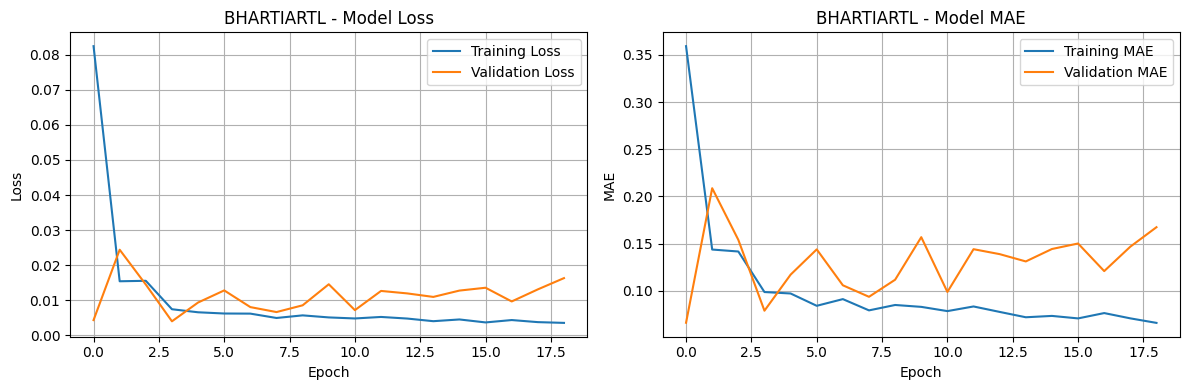


🎯 Training model for HDFCBANK
📊 Loaded 247 records for HDFCBANK
📈 Data split: Train=134, Val=15, Test=38
🏗️ Model built with input shape: (60, 13)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1114 - mae: 0.4054 - val_loss: 0.0134 - val_mae: 0.1367 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0231 - mae: 0.1772 - val_loss: 0.0400 - val_mae: 0.2675 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0221 - mae: 0.1725 - val_loss: 0.0159 - val_mae: 0.1549 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0093 - mae: 0.1067 - val_loss: 0.0047 - val_mae: 0.0833 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0124 - mae: 0.1314 - val_loss: 0.0114 - val_mae: 0.1275 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0109 - mae: 0.1128 - val_loss: 0.0137 - val_mae: 0.1428 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━

✅ HDFCBANK - RMSE: 106.25, R²: -2.8207


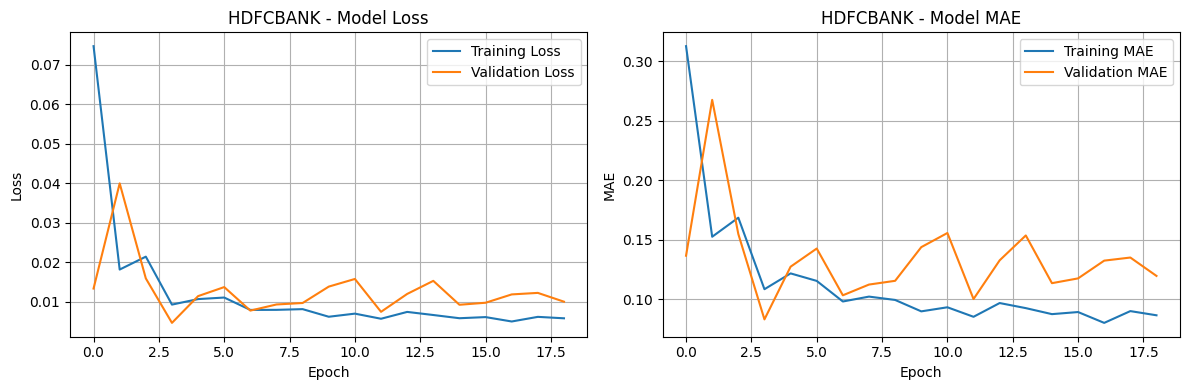


🎯 Training model for INFY
📊 Loaded 247 records for INFY
📈 Data split: Train=134, Val=15, Test=38
🏗️ Model built with input shape: (60, 13)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2224 - mae: 0.6132 - val_loss: 0.1408 - val_mae: 0.5291 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0280 - mae: 0.1945 - val_loss: 0.1082 - val_mae: 0.4631 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0184 - mae: 0.1539 - val_loss: 0.0616 - val_mae: 0.3477 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0185 - mae: 0.1592 - val_loss: 0.1240 - val_mae: 0.4959 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0144 - mae: 0.1387 - val_loss: 0.1136 - val_mae: 0.4745 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0135 - mae: 0.1316 - val_loss: 0.0824 - val_mae: 0.4035 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━

✅ INFY - RMSE: 282.11, R²: -17.9716


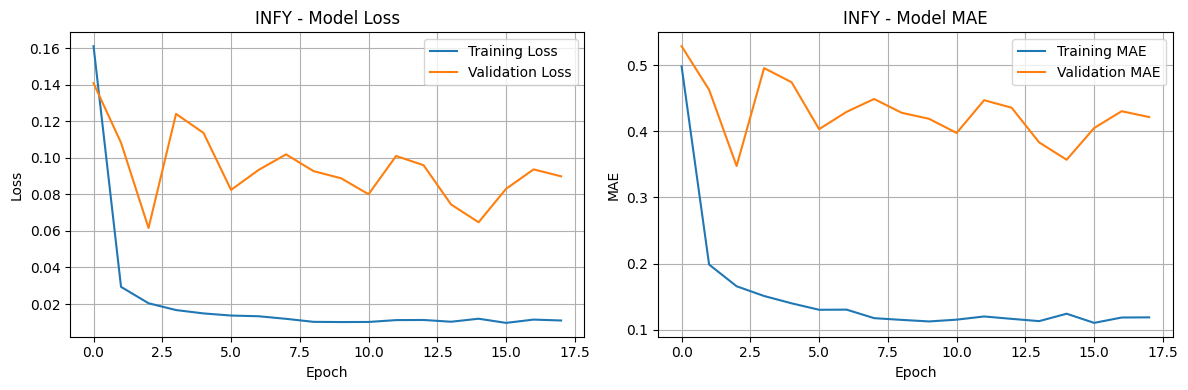


🎯 Training model for RELIANCE
📊 Loaded 247 records for RELIANCE
📈 Data split: Train=134, Val=15, Test=38
🏗️ Model built with input shape: (60, 13)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0628 - mae: 0.2673 - val_loss: 0.0010 - val_mae: 0.0373 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0137 - mae: 0.1332 - val_loss: 0.0118 - val_mae: 0.1475 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0085 - mae: 0.1049 - val_loss: 0.0071 - val_mae: 0.1109 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0063 - mae: 0.0911 - val_loss: 0.0096 - val_mae: 0.1319 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0075 - mae: 0.0941 - val_loss: 0.0075 - val_mae: 0.1152 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0062 - mae: 0.0886 - val_loss: 0.0047 - val_mae: 0.0873 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━

✅ RELIANCE - RMSE: 73.64, R²: 0.3248


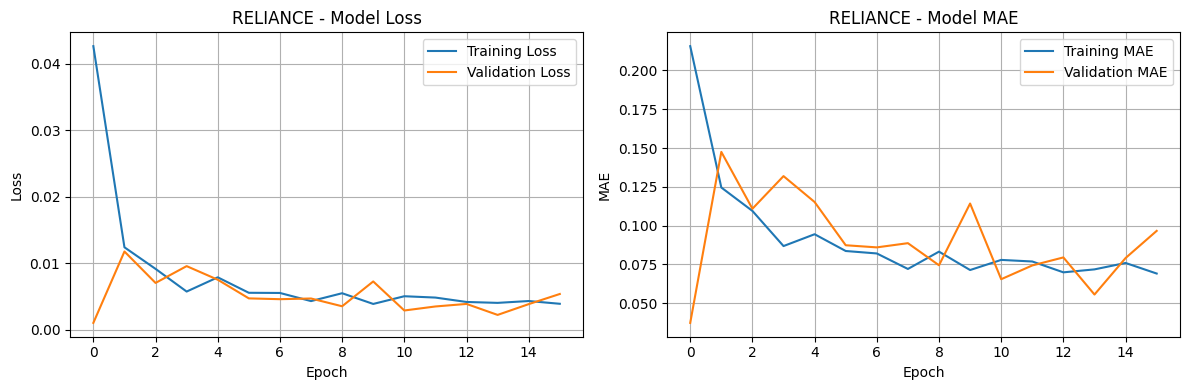


🎯 Training model for TCS
📊 Loaded 247 records for TCS
📈 Data split: Train=134, Val=15, Test=38
🏗️ Model built with input shape: (60, 13)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.1361 - mae: 0.4619 - val_loss: 0.0694 - val_mae: 0.3668 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0257 - mae: 0.1894 - val_loss: 0.0385 - val_mae: 0.2713 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0167 - mae: 0.1518 - val_loss: 0.0422 - val_mae: 0.2844 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0164 - mae: 0.1404 - val_loss: 0.0274 - val_mae: 0.2264 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0148 - mae: 0.1366 - val_loss: 0.0118 - val_mae: 0.1407 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0133 - mae: 0.1311 - val_loss: 0.0120 - val_mae: 0.1410 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━

✅ TCS - RMSE: 238.89, R²: -4.4911


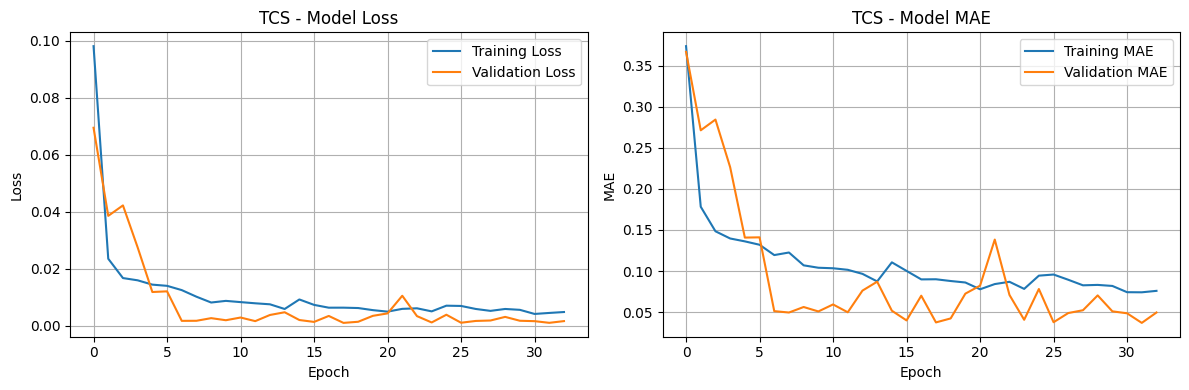

In [15]:
data_files = [f for f in os.listdir('../data') if f.endswith('_upstox_data.csv')]
print(f"Found {len(data_files)} data files: {data_files}")

symbols = []
for file in data_files:
    symbol = file.replace('_upstox_data.csv', '')
    symbols.append(symbol)

print(f"Training models for: {symbols}")

models_performance = {}

for symbol in symbols:
    print(f"\n🎯 Training model for {symbol}")
    
    # Load data
    try:
        data = pd.read_csv(f'../data/{symbol}_upstox_data.csv')
        data['Date'] = pd.to_datetime(data['Date'])
        print(f"📊 Loaded {len(data)} records for {symbol}")
    except FileNotFoundError:
        print(f"❌ Data file not found for {symbol}")
        continue
    
    # Prepare data
    preprocessor = StockDataPreprocessor()
    data = preprocessor.prepare_features(data)
    X, y = preprocessor.create_sequences(data)
    
    if len(X) < 100:  # Need sufficient data for training
        print(f"❌ Insufficient data for {symbol} ({len(X)} sequences)")
        continue
    
    # Split data
    split_idx = int(len(X) * 0.8)
    val_split_idx = int(split_idx * 0.9)
    
    X_train = X[:val_split_idx]
    y_train = y[:val_split_idx]
    X_val = X[val_split_idx:split_idx]
    y_val = y[val_split_idx:split_idx]
    X_test = X[split_idx:]
    y_test = y[split_idx:]
    
    print(f"📈 Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    
    # Train model
    model = StockLSTMModel(input_shape=(X.shape[1], X.shape[2]))
    print(f"🏗️ Model built with input shape: {model.input_shape}")
    
    history = model.train(X_train, y_train, X_val, y_val, epochs=50)
    
    # Evaluate
    metrics = model.evaluate(X_test, y_test, preprocessor)
    models_performance[symbol] = metrics
    
    print(f"✅ {symbol} - RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R2']:.4f}")
    
    # Save model and preprocessor
    os.makedirs('../models', exist_ok=True)
    model.model.save(f'../models/{symbol}_model.h5')
    joblib.dump(preprocessor, f'../models/{symbol}_preprocessor.pkl')
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{symbol} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{symbol} - Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'../models/{symbol}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


#### MODEL PERFORMANCE SUMMARY

In [16]:
# Models Performance Summary
print("\n" + "="*60)
print("🏆 MODELS PERFORMANCE SUMMARY")
print("="*60)

if models_performance:
    performance_df = pd.DataFrame(models_performance).T
    performance_df = performance_df.round(4)
    print(performance_df.to_string())
    
    # Save performance summary
    performance_df.to_csv('../models/models_performance.csv')
    print(f"\n💾 Performance summary saved to ../models/models_performance.csv")
    
    # Best model analysis
    best_r2 = performance_df['R2'].idxmax()
    best_rmse = performance_df['RMSE'].idxmin()
    
    print(f"\n🥇 Best R² Score: {best_r2} ({performance_df.loc[best_r2, 'R2']:.4f})")
    print(f"🥇 Best RMSE: {best_rmse} ({performance_df.loc[best_rmse, 'RMSE']:.2f})")
else:
    print("❌ No models were successfully trained")

print(f"\n🎉 Model training completed!")
print(f"📊 Successfully trained {len(models_performance)} models")
print(f"💾 Models saved to ../models/ directory")


🏆 MODELS PERFORMANCE SUMMARY
                   MSE       MAE      RMSE       R2     MAPE
BHARTIARTL  25033.7577  150.5334  158.2206  -8.6627   8.1614
HDFCBANK    11288.7735   99.4520  106.2486  -2.8207   5.1776
INFY        79588.7629  273.1125  282.1148 -17.9716  18.3335
RELIANCE     5422.4060   62.8898   73.6370   0.3248   4.6750
TCS         57067.4346  195.4604  238.8879  -4.4911   5.7683

💾 Performance summary saved to ../models/models_performance.csv

🥇 Best R² Score: RELIANCE (0.3248)
🥇 Best RMSE: RELIANCE (73.64)

🎉 Model training completed!
📊 Successfully trained 5 models
💾 Models saved to ../models/ directory
